This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

## How the Stats, Elements, and Rarity of a Pal Influence its Price

#### By Samuel Hirn, Sean O'Donnell, Stephen Sodipo

In [1]:
# webscraping
import requests
import pandas as pd
from bs4 import BeautifulSoup

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model 1
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# model 2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np


## Introduction

Palworld is a unique survival crafting game that combines creature collection mechanics with base building and combat elements. In Palworld, players can capture, train, and utilize various Pals, each with distinct stats and abilities that affect their performance in different tasks such as combat, resource gathering, and base management. The game's economy includes a pricing system for Pals, which creates an interesting opportunity to analyze what factors drive their market value.

Understanding the relationship between Pal characteristics and their prices has practical implications for players looking to optimize their gameplay strategies. By analyzing data from palworld.gg, a database of all Pals and their attributes, we can investigate which statistical features most strongly influence a Pal's price. Our primary research question is: **Which combination of stats, elemental composition, and rarity levels provides the most accurate prediction of a Pal's market price in the game?"**

This analysis could help players make informed decisions about which Pals to prioritize for capture or breeding, and provide insights into the game's economic balancing mechanics.

-----

## Data

**Website Scraped:**

Main Pal listing page (https://palword.gg/pals) and individual Pal detail pages (https://palworld.gg/pal/[pal_name])

**Information Scraped:**

The following attributes were extracted for each Pal:

Name, Rarity, Elements (can have multiple), HP, Defense, Melee Attack, Shot Attack, Crafting Speed, Support, Stamina, Running Speed, Sprinting Speed, Slow Walk Speed, Price, and a direct link to each Pal's detail page

**Data Cleaning Process:**

Several cleaning steps were implemented during the scraping process:

- Type Conversion: Converted numeric stat values from strings to integers where applicable, keeping non-numeric values as strings
- Missing Value Handling: Initialized all stat fields with None values to handle cases where certain stats might be missing from a Pal's page
- Element Formatting: Converted the list of elements for each Pal into a comma-separated string format for easier DataFrame storage
- Data Flattening: Restructured the nested dictionary format (with separate Stats and Elements dictionaries) into a flat structure suitable for pandas DataFrame creation
- Error Handling: Implemented try-except blocks to skip Pals that couldn't be properly scraped, preventing the entire process from failing due to individual page issues
- Standardized Naming: Converted stat names to a consistent format (lowercase with underscores) for uniform column naming in the final DataFrame

-----

### Webscraping and cleaning functions overview

- `extract_soup()`
    - build url and return soup object
- `fetch_pal(url: str) -> BeautifulSoup`
    - Fetches HTML content from a given URL and returns a parsed BeautifulSoup object.
- `parse_pals_data(main_soup: BeautifulSoup) -> list[dict]`
    - Extracts name and detail page links for all Pals from the main listing page.
- `strip_pal_stats(soup: BeautifulSoup) -> dict`
    - Scrapes individual Pal statistics including name, rarity, elements, and various stat values from a Pal's detail page.
- `create_dataframe() -> pd.DataFrame`
    - Orchestrates the entire scraping process by fetching all Pals, extracting their stats, and organizing the data into a pandas DataFrame.

## Webscraping and cleaning

In [2]:
def fetch_pal(url: str) -> BeautifulSoup:
    """
    Args:
        url (str): The inputted url link for a chosen pal

    Returns:
        BeatifulSoup: the parsed content for the given pal
    """
    # first get the link
    resp = requests.get(url)
    # have a checker in the event the input is wrong
    resp.raise_for_status()
    resp = resp.text
    return BeautifulSoup(resp, features="lxml")


def parse_pals_data(main_soup: BeautifulSoup) -> list[dict]:
    """
    Parses Pal data from palworld.gg HTML using BeautifulSoup,
    extracting Name and link to each Pal's detail page.

    Args:
        main_soup (BeautifulSoup): HTML content of the page.

    Returns:
        list[dict]: List of pals with 'Name' and 'Link'.
    """
    pals = []

    # Get the main section
    pals_section = main_soup.find('section', class_='pals-list')
    if not pals_section:
        print("No pals-list section found.")
        return []

    # Each Pal is a div with class "pal"
    pal_divs = pals_section.find_all('div', class_='pal')

    for pal_div in pal_divs:
        try:
            a_tag = pal_div.find('a', href=True)
            if not a_tag:
                continue

            detail_url = a_tag['href']
            full_url = "https://palworld.gg" + detail_url

            name_div = a_tag.find('div', class_='name')
            name = name_div.get_text(strip=True) if name_div else "Unknown"

            pals.append({"Name": name, "Link": full_url})

        except Exception as e:
            print(f"Error parsing pal card: {e}")
            continue

    return pals


def strip_pal_stats(soup: BeautifulSoup) -> dict:
    """
    Extracts individual stats from a Pal's page.

    Args:
        soup(BeautifulSoup): Parsed data from the Pal's page

    Return:
        dict: Dictionary of the stats
    """

    # Retrieve the name of the Pal
    name = soup.find('h1', class_='name').text.strip() if soup.find('h1', class_='name') else None

    # extract the rarity
    rarity_div = soup.find('div', class_='rarity')
    rarity = rarity_div.text.strip() if rarity_div else None

    # Element name
    elements = []
    elements_div = soup.find('div', class_='elements')
    if elements_div:
        elements_divs = elements_div.find_all('div', class_='element')
        for elem_div in elements_divs:
            # this should get the element name
            elem_name = elem_div.find('div', class_='name')
            if elem_name:
                elements.append(elem_name.text.strip())

    # stats
    # Initialize stats dictionary with expected fields
    stats = {
        'name': name,
        'rarity': rarity,
        'hp': None,
        'defense': None,
        'crafting_speed': None,
        'melee_attack': None,
        'shot_attack': None,
        'price': None,
        'stamina': None,
        'support': None,
        'running_speed': None,
        'sprinting_speed': None,
        'slow_walk_speed': None
    }

    stats_div = soup.find('div', class_='stats')
    # reach the stats section
    if stats_div:
        items_divs = stats_div.find_all('div', class_='item')
        # go into each item
        for item in items_divs:
            stat_name_div = item.find('div', class_='name')
            stat_value_div = item.find('div', class_='value')

            # using the name and value of the stats add to the dictionary
            if stat_name_div and stat_value_div:
                stat_name = stat_name_div.text.strip().lower().replace(' ', '_')
                stat_value = stat_value_div.text.strip()
                try:
                    stat_value = int(stat_value)
                except ValueError:
                    pass  # Keep as string if not an int

                if stat_name in stats:
                    stats[stat_name] = stat_value

    return {
        "Name": stats['name'],
        "Rarity": stats['rarity'],
        "Elements": elements,
        "Stats": {
            "HP": stats['hp'],
            "Defense": stats['defense'],
            "Crafting Speed": stats['crafting_speed'],
            "Melee Attack": stats['melee_attack'],
            "Shot Attack": stats['shot_attack'],
            "Support": stats['support'],
            "Stamina": stats['stamina'],
            "Price": stats['price'],
            "Running Speed": stats['running_speed'],
            "Sprinting Speed": stats['sprinting_speed'],
            "Slow Walk Speed": stats['slow_walk_speed'],
        }
    }


def create_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame from the list of Pal data

    Returns:
        DataFrame: Cleaned Dataframe ready for analysis
    """

    main_pal_soup = fetch_pal(BASE_URL)

    # get the basic information
    pals_info = parse_pals_data(main_pal_soup)

    full_data = []
    # loop through the pals
    for idfx, pal in enumerate(pals_info):
        try:
            print(f"Processing {idfx + 1}/{len(pals_info)}: {pal['Name']}")
            detail_soup = fetch_pal(pal["Link"])
            stats = strip_pal_stats(detail_soup)

            # flatten the stats dictionary
            rec = {
                'Name': stats.get('Name'),
                "Link": pal.get("Link"),
                "Rarity": stats['Rarity']
            }

            # add stats (HP, Defense, etc.)
            for key, value in stats.get("Stats", {}).items():
                rec[key] = value
            # add elements as a joined string
            rec["Elements"] = ", ".join(stats.get("Elements", []))

            full_data.append(rec)
        except Exception as e:
            print(f"Skipping {pal.get('Name', '')}: {e}")
            continue

    df = pd.DataFrame(full_data)
    return df

In [3]:
BASE_URL = "https://palworld.gg/pals"

df = create_dataframe()
df.to_csv("test_data1.csv", index=False)
df.head(10)

Processing 1/225: Anubis#100
Processing 2/225: Arsox#42
Processing 3/225: Astegon#98
Processing 4/225: Azurmane#136
Processing 5/225: Azurobe#82
Processing 6/225: Azurobe Cryst#82
Processing 7/225: Bastigor#137
Processing 8/225: Beakon#73
Processing 9/225: Beegarde#50
Processing 10/225: Bellanoir#112
Processing 11/225: Bellanoir Libero#112
Processing 12/225: Blazamut#96
Processing 13/225: Blazamut Ryu#96
Processing 14/225: Blazehowl#84
Processing 15/225: Blazehowl Noct#84
Processing 16/225: Blue Slime#-1
Processing 17/225: Braloha#145
Processing 18/225: Bristla#30
Processing 19/225: Broncherry#86
Processing 20/225: Broncherry Aqua#86
Processing 21/225: Bushi#72
Processing 22/225: Bushi Noct#72
Processing 23/225: Caprity#35
Processing 24/225: Caprity Noct#35
Processing 25/225: Cattiva#2
Processing 26/225: Cave Bat#-1
Processing 27/225: Cawgnito#44
Processing 28/225: Celaray#25
Processing 29/225: Celaray Lux#25
Processing 30/225: Celesdir#132
Processing 31/225: Chikipi#3
Processing 32/22

,Name,Link,Rarity,HP,Defense,Crafting Speed,Melee Attack,Shot Attack,Support,Stamina,Price,Running Speed,Sprinting Speed,Slow Walk Speed,Elements
0,Anubis,https://palworld.gg/pal/anubis,10Epic,120,100,100,130,130,100,100,4960,800,1000,80,Earth
1,Arsox,https://palworld.gg/pal/arsox,4Common,85,95,100,100,95,100,120,3520,700,1050,87,Fire
2,Astegon,https://palworld.gg/pal/astegon,9Epic,100,125,100,100,125,100,300,8200,700,1100,100,"Dragon, Dark"
3,Azurmane,https://palworld.gg/pal/azurmane,7Rare,130,110,100,100,120,100,220,6680,900,1260,90,Electricity
4,Azurobe,https://palworld.gg/pal/azurobe,7Rare,110,100,100,70,100,100,160,5600,600,900,75,"Water, Dragon"
5,Azurobe Cryst,https://palworld.gg/pal/azurobe-cryst,8Epic,115,105,100,100,105,100,160,6720,600,900,75,"Ice, Dragon"
6,Bastigor,https://palworld.gg/pal/bastigor,8Epic,140,120,100,100,130,100,270,9020,750,1100,120,Ice
7,Beakon,https://palworld.gg/pal/beakon,6Rare,105,80,100,100,115,100,160,7490,750,1200,100,Electricity
8,Beegarde,https://palworld.gg/pal/beegarde,4Common,80,90,100,100,90,100,100,1880,450,550,125,Leaf
9,Bellanoir,https://palworld.gg/pal/bellanoir,20Legendary,120,100,100,100,150,100,100,10030,600,800,100,Dark


In [4]:
# Numeric rarity (e.g., from "10Epic" to 10)
df['Num_Rarity'] = df['Rarity'].str.extract(r'(\d+)').astype(int)

# Number of elements (count the elements split by comma)
df['Num_Elements'] = df['Elements'].apply(lambda x: len(x.split(', ')) if isinstance(x, str) else 0)

# Average of stats
stat_cols = ['HP', 'Defense', 'Crafting Speed', 'Melee Attack', 'Shot Attack', 'Support', 'Stamina']
df['Avg_Stats'] = df[['HP', 'Defense', 'Melee Attack', 'Shot Attack', 'Support', 'Stamina']].mean(axis=1)

df.head(10)


,Name,Link,Rarity,HP,Defense,Crafting Speed,Melee Attack,Shot Attack,Support,Stamina,Price,Running Speed,Sprinting Speed,Slow Walk Speed,Elements,Num_Rarity,Num_Elements,Avg_Stats
0,Anubis,https://palworld.gg/pal/anubis,10Epic,120,100,100,130,130,100,100,4960,800,1000,80,Earth,10,1,113.333333
1,Arsox,https://palworld.gg/pal/arsox,4Common,85,95,100,100,95,100,120,3520,700,1050,87,Fire,4,1,99.166667
2,Astegon,https://palworld.gg/pal/astegon,9Epic,100,125,100,100,125,100,300,8200,700,1100,100,"Dragon, Dark",9,2,141.666667
3,Azurmane,https://palworld.gg/pal/azurmane,7Rare,130,110,100,100,120,100,220,6680,900,1260,90,Electricity,7,1,130.000000
4,Azurobe,https://palworld.gg/pal/azurobe,7Rare,110,100,100,70,100,100,160,5600,600,900,75,"Water, Dragon",7,2,106.666667
5,Azurobe Cryst,https://palworld.gg/pal/azurobe-cryst,8Epic,115,105,100,100,105,100,160,6720,600,900,75,"Ice, Dragon",8,2,114.166667
6,Bastigor,https://palworld.gg/pal/bastigor,8Epic,140,120,100,100,130,100,270,9020,750,1100,120,Ice,8,1,143.333333
7,Beakon,https://palworld.gg/pal/beakon,6Rare,105,80,100,100,115,100,160,7490,750,1200,100,Electricity,6,1,110.000000
8,Beegarde,https://palworld.gg/pal/beegarde,4Common,80,90,100,100,90,100,100,1880,450,550,125,Leaf,4,1,93.333333
9,Bellanoir,https://palworld.gg/pal/bellanoir,20Legendary,120,100,100,100,150,100,100,10030,600,800,100,Dark,20,1,111.666667


### Data overview

-----
**Sample Data:**

Cleaned data preview is shown above.

**Target Variable:**

Price is our target variable, ranging from 1,000 to 24,900 (mean: 4,535)
All 225 Pals have price values (no missing data)

**Feature Summary:**

Combat Stats: HP (60-150), Defense (50-145), Melee Attack (50-150), Shot Attack (50-150)

Utility Stats: All Pals have Crafting Speed of 100, Support mostly at 100 (range: 30-150)

Movement Stats: Running Speed (240-2000), Sprinting Speed has 2 anomalous negative values

Categorical: Rarity levels from 1Common to 20Legendary; 9 element types with 72% of Pals having single element

**Columns Added**

Num_Rarity: The number of rarity categories associated with each Pal, based on its listed rarities. This feature helps analyze whether Pals with more rarity types tend to be priced higher, explored through a bar chart of average Price by Num_Rarity.

Num_Elements: The number of elemental types associated with each Pal, based on its listed elements. This feature investigates if Pals with more elements command higher or more variable prices, examined using a boxplot of Price by Num_Elements

Avg_Stats: The average of all individual stat values for each Pal, giving a standardized measure of overall performance. This feature is used to explore how a Pal's overall strength influences its price, shown via a scatterplot relating Avg_Stats to Price.



**Potential Data Issues:**

- No data on skills/abilities, work suitability, food consumption, or capture difficulty - which could significantly impact price
- 2 Pals have negative Sprinting Speed values (-1), suggesting data collection errors
- Crafting Speed is constant at 100 for all Pals, providing no predictive value
- Only 8 Legendary Pals vs 30+ Common ones could affect model performance

-----

### **Visualizations**

### Overview of Functions

- `plot_price_vs_stats(df)` – Creates a scatterplot of Price vs. Average Stats, colored by Rarity.
- `plot_avg_price_by_rarity(df)` – Generates a bar plot of the average Price grouped by rarity level.
- `plot_price_distribution_by_elements(df)` – Produces a box plot showing Price distributions across the number of elements.

#### Visualization 1: Avg_Stats vs Price (Scatterplot)

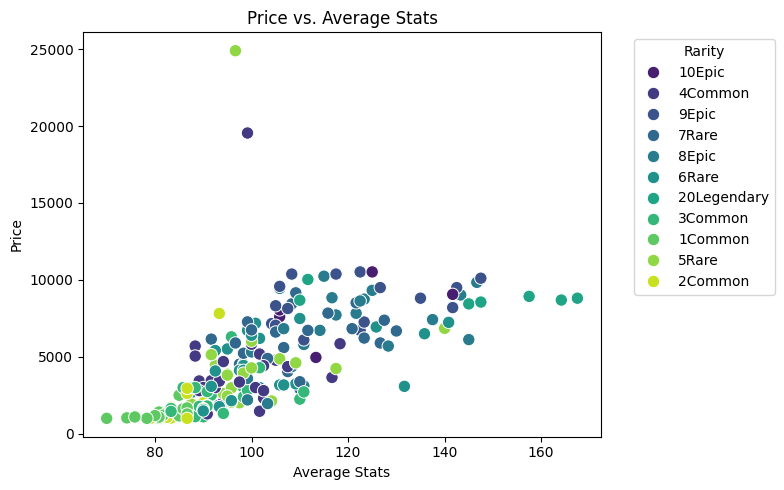

<Axes: title={'center': 'Price vs. Average Stats'}, xlabel='Average Stats', ylabel='Price'>

In [5]:
def plot_price_vs_stats(df):
    """
    Create a scatterplot showing the relationship between Price and Average Stats,
    colored by Rarity.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'Avg_Stats', 'Price', and 'Rarity'.

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the scatterplot.
    """
    plt.figure(figsize=(8, 5))
    ax = sns.scatterplot(x='Avg_Stats', y='Price', data=df, hue='Rarity', palette='viridis', s=80)
    plt.title('Price vs. Average Stats')
    plt.xlabel('Average Stats')
    plt.ylabel('Price')
    plt.legend(title='Rarity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return ax


plot_price_vs_stats(df)


### Interpretation

**Why this visualization was made**

This scatterplot was created to examine how a Pal's average stats and rarity level interact to influence price. Since the research question asks which combination of stats, elemental composition, and rarity levels most strongly predicts price, this plot helps to identify whether certain stat-rarity parings consistently result in higher prices, and whether outliers suggest an added influence from elemental composition.

**What we learned**

There is a clear positive correlation between average stats and price. Pals with average stats in the 80-100 range typically sell for under 5,000, while those in the 120-140 range often reach 8,000-10,000. The highest state range (160+) still commands prices of around 9,000 to 10,000. A notable outlier, with stats near 100 but priced over 25,000, suggests that additional traits-such as duel-elemental composition-can significantly elevate price value. This supports the idea that high stats combined with high rarity are strong predictors of high price, but the highest prices may result from the combined effect of all three factors.





#### Visualization 2: Average Price vs. Num_Rarity (Bar Graph)

/var/folders/lx/l9dwg8ts60b2hfv6c5ws6_1w0000gn/T/ipykernel_14122/817524543.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Num_Rarity', y='Price', data=avg_price_rarity, palette='coolwarm')


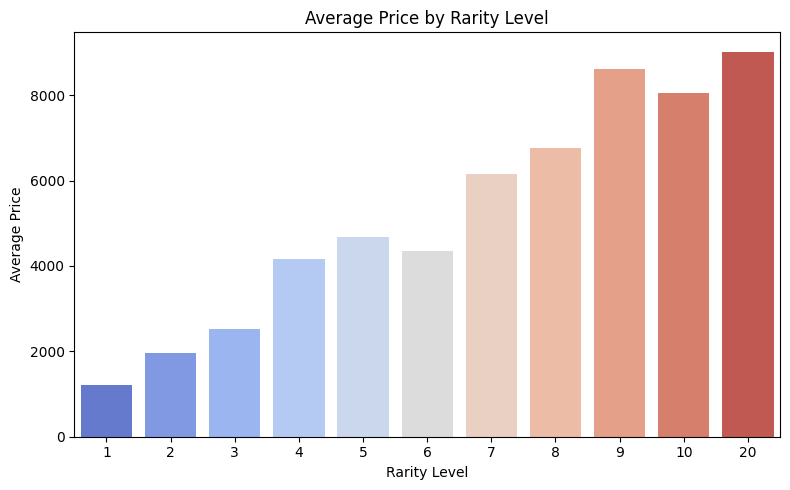

<Axes: title={'center': 'Average Price by Rarity Level'}, xlabel='Rarity Level', ylabel='Average Price'>

In [6]:
def plot_avg_price_by_rarity(df):
    """
    Create a bar plot showing the average Price grouped by rarity level.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'Num_Rarity' and 'Price'.

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the bar plot.
    """
    avg_price_rarity = df.groupby('Num_Rarity')['Price'].mean().reset_index()

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Num_Rarity', y='Price', data=avg_price_rarity, palette='coolwarm')
    plt.title('Average Price by Rarity Level')
    plt.xlabel('Rarity Level')
    plt.ylabel('Average Price')
    plt.tight_layout()
    plt.show()
    return ax


plot_avg_price_by_rarity(df)

### Interpretation

**Why this visualization was made**

This barplot isolates rarity to assess its standalone effect before combining it with stats and elemental composition in later predictive modeling. This is critical for our research question because if rarity alone explains large price differences, it is likely to be a dominant factor in the most valuable combinations.

**What we learned**

Average price increases steadily with rarity level. At rarity level 1, the average price is about 1,200. By rarity level 4, it rises to 4,300, and by level 7 it reaches 6,200. The highest prices occur at rarity levels 9(~8,500), 10(~8,000), and 20(~8,900). This is a 7x increase from the lowest to the highest rarity. These results confirm that rarity alone is a major driver of price, and when paired with high stats and certain elemental compositions, it is likely to form part of the strongest predictive combination.

#### Visualization 3: Num_Elements vs Price (Box Plot)

/var/folders/lx/l9dwg8ts60b2hfv6c5ws6_1w0000gn/T/ipykernel_14122/1700781481.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Num_Elements', y='Price', data=df, palette='magma')


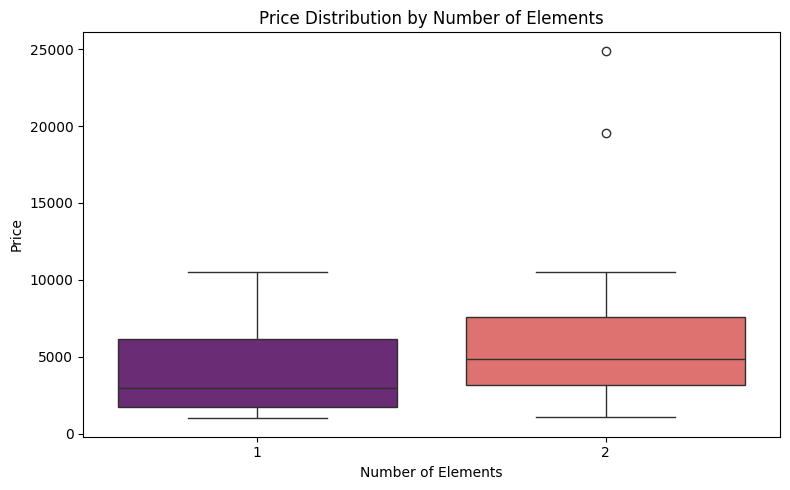

<Axes: title={'center': 'Price Distribution by Number of Elements'}, xlabel='Number of Elements', ylabel='Price'>

In [7]:
def plot_price_distribution_by_elements(df):
    """
    Create a box plot showing the distribution of Price across the number of elements.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'Num_Elements' and 'Price'.

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the box plot.
    """
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(x='Num_Elements', y='Price', data=df, palette='magma')
    plt.title('Price Distribution by Number of Elements')
    plt.xlabel('Number of Elements')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()
    return ax


plot_price_distribution_by_elements(df)

### Interpretation

**Why this visualization was made**

This boxplot tests whether different elemental compositions impact price and provides insight into how this factor may enhance the effects of stats and rarity in predicting high-value Pals. Understanding this relationship is important for our research question because elemental composition could be the factor that pushes certain stat–rarity combinations into the highest price ranges.

**What we learned**

Pals with single-element composition have a median price of 5,000, with most prices between 2,500 and 9,000. Rare outliers exceed 20,000. Pals with dual-element composition have a higher median price of 6,000 and a broader range of 3,500–10,000. This group also contains the highest price observed (over 25,000). While elemental composition alone is not as strong a predictor as rarity or stats, it appears to magnify price when combined with high values in the other two variables, making it an important component of top-tier combinations.

## **Models**

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering.

### Overview of Functions for Model 1

- fit_log_linear_model(df, features, target): Fits a multiple linear regression on the log-transformed target and adds back-transformed predictions to the DataFrame.
- plot_residuals_vs_fitted(model): Plots residuals versus fitted values to assess model assumptions.
- plot_actual_vs_predicted(df_with_preds, target, pred_col) - Plots actual target values against predicted values with a 45-degree perfect prediction line.

#### Model 1: Multiple Linear Regression

In [8]:
def fit_log_linear_model(df, features=("Avg_Stats", "Num_Rarity", "Num_Elements"), target="Price"):
    """
    Fit a multiple linear regression on log-transformed target and back-transform predictions.

    Parameters
    ----------
    df : pandas.DataFrame
        Data containing the target and features.
    features : sequence of str, optional
        Predictor columns. Default is ('Avg_Stats', 'Num_Rarity', 'Num_Elements').
    target : str, default="Price"
        Target column name.

    Returns
    -------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted OLS model.
    df_out : pandas.DataFrame
        Copy of df with predicted log and predicted target columns.
    """
    df_out = df.copy()
    y_log = np.log(df_out[target])
    X = sm.add_constant(df_out[list(features)])
    model = sm.OLS(y_log, X).fit()

    predicted_log = model.predict(X)
    df_out["Predicted_Log"] = predicted_log
    df_out[f"Predicted_{target}"] = np.exp(predicted_log)

    print(model.summary())
    return model, df_out


model, df_pred = fit_log_linear_model(df)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     112.2
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           3.53e-44
Time:                        20:06:12   Log-Likelihood:                -147.47
No. Observations:                 225   AIC:                             302.9
Df Residuals:                     221   BIC:                             316.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7027      0.232     24.616   

### Residual Plot

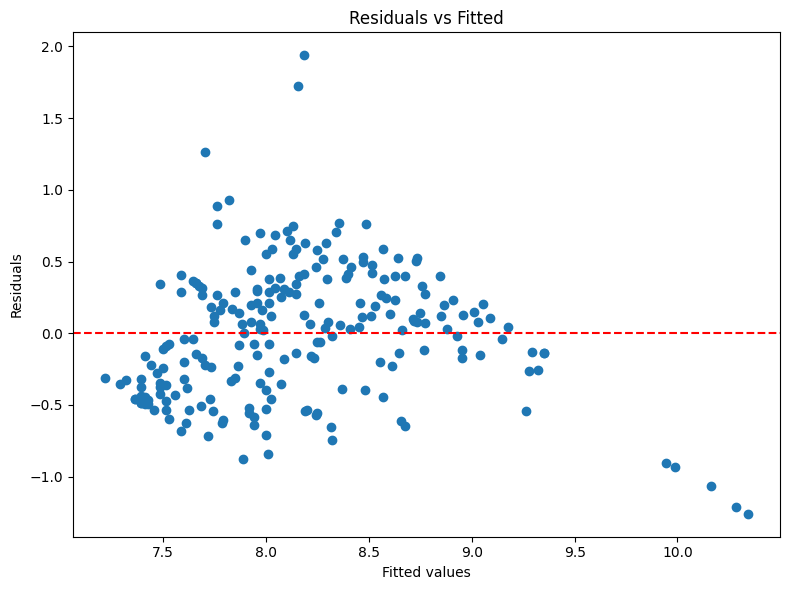

<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

In [9]:
def plot_residuals_vs_fitted(model):
    """
    Plot residuals versus fitted values for a fitted regression model.

    Parameters
    ----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        A fitted OLS model.

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the residuals vs. fitted plot.
    """
    fitted_vals = model.fittedvalues
    residuals = model.resid

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.scatter(fitted_vals, residuals)
    ax.axhline(y=0, color="red", linestyle="--")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals vs Fitted")
    plt.tight_layout()
    plt.show()
    return ax


plot_residuals_vs_fitted(model)

### Actual vs. Predicted Price

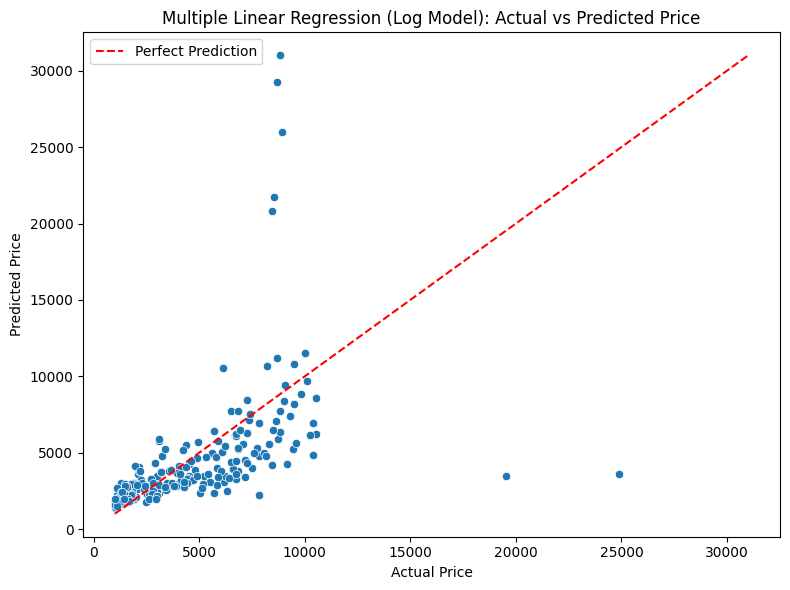

<Axes: title={'center': 'Multiple Linear Regression (Log Model): Actual vs Predicted Price'}, xlabel='Actual Price', ylabel='Predicted Price'>

In [10]:
def plot_actual_vs_predicted(df_with_preds, target="Price", pred_col=None):
    """
    Plot actual target values against predicted values with a 45-degree line.

    Parameters
    ----------
    df_with_preds : pandas.DataFrame
        Data containing the true target and predictions.
    target : str, default="Price"
        True target column name.
    pred_col : str, optional
        Column name of predictions. Defaults to "Predicted_{target}".

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the actual vs. predicted scatterplot.
    """
    if pred_col is None:
        pred_col = f"Predicted_{target}"

    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(x=target, y=pred_col, data=df_with_preds)
    min_val = min(df_with_preds[target].min(), df_with_preds[pred_col].min())
    max_val = max(df_with_preds[target].max(), df_with_preds[pred_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Multiple Linear Regression (Log Model): Actual vs Predicted Price")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return ax


plot_actual_vs_predicted(df_pred)

## MSE and Naive Mean Baseline

In [11]:
# MSE
mse = mean_squared_error(df_pred["Price"], df_pred["Predicted_Price"])
rmse = np.sqrt(mse)

print(f"MSE: {mse:.0f}")
print(f"RMSE: {rmse:.0f}")

# Baseline
y = df_pred["Price"].to_numpy()  # actuals
yhat_base = np.full_like(y, y.mean(), float)  # predict the overall mean for everyone

mse_base = np.mean((y - yhat_base) ** 2)
rmse_base = float(np.sqrt(mse_base))

print(f"Baseline (mean) — MSE: {mse_base:.0f} | RMSE: {rmse_base:.0f}")

MSE: 12797284
RMSE: 3577
Baseline (mean) — MSE: 10622401 | RMSE: 3259


### Interpretation of Model 1

**Model Selection and Purpose**

For our first predictive approach, we applied a multiple linear regression (MLR) model to estimate Pal prices. This modeling choice was intentional because MLR can simultaneously assess the effect of multiple independent variables on a sole dependent variable while controlling for the influence of each predictor. Our dependent variable was log-transformed price (ln(Price)) rather than raw price. This change was applied to steady variance, shrink the influence of extreme price outliers, and make the model coefficients in terms of percentage changes. The predictors chosen for the model-**Avg_Stats**, **Num_Rarity**, and **Num_Elements**-were chosen because they capture key attributes that directly influence perceived value: combat performance metrics, rarity level, and elemental diversity. By including these together into one regression, we can evaluate their independent contributions to price while accounting for correlations between them.

**Model Equation and Coefficient Interpretation**

The fitted equation is:

ln(Price) = 5.7027 + 0.0177 * Avg_Stats + 0.0736 * Num_Rarity + 0.2008 * Num_Elements

Because the dependent variable is log-transformed, each coefficient can be interpreted as the approximate **percentage change in price** for a one-unit change in the predictor, holding other variables constant.

- **Avg_Stats (0.0177)**: A one-point increase in average stats is associated with a **1.78% increase** in predicted price, holding rarity and elements constant. For example, an increase of 10 stat points corresponds to a roughly **17.8% higher** predicted price.
- **Num_Rarity (0.0736)**: Each one-step increase in rarity level leads to about a **7.64% price increase** when other variables are held constant. For instance, moving from rarity level 5 to 10 implies about a **32.8%** higher price.
- **Num_Elements (0.2008)**: Moving from a single-element Pal to a dual-element Pal increases the predicted price by about **22.2%**, assuming rarity and stats remain fixed.

**Model Performance**

The model achieves an **R^2 of 0.604**, meaning it explains approximately 60% of the variation on log-transformed price. This is a strong result given the inherent variability of market-driven prices, which are influenced by subjective and external factors not included in the dataset. The **F-statistic** (112.2) and its associated p-value (< 0.01) indicate that the model as a whole is statistically significant, and each individual predictor has a p-value below 0.01, confirming their contributions to explaining price variation. On the original (unlogged) price scale, the back-transformed predictions yield MSE = 12,797,284 and RMSE = 3,577. On the original scale, an RMSE of around 3,577 means that the log-linear model's predictions are typically off by about 3.6k in price (with MSE reflecting that large errors are penalized heavily). The log-linear model's MSE (around 12.8M) and RMSE(around 3.6k) are worse than a naive mean baseline (around 10.6 MSE, around 3.26K RMSE), indicating larger average squared errors and a higher typical miss; we therefore treat this model as explanatory and will rely on our Random Forest model for predictive accuracy

**Diagnostic Insights**

Two diagnostic plots were created to assess model fit and validity. The **Residuals vs. Fitted plot** shows that residuals are mostly centered around zero, suggesting the linearity assumption is reasonable, backing the linearity assumption between predictors and log-transformed price. A minor increase in residual spread at higher fitted values indicates mild heteroscedasticity, suggesting that price variability is greater for higher-priced pals. Some outliers are present above and below the zero line, representing cases where the model under or overpredicts due to unusual combinations of attributes.

The **Actual vs. Predicted Price** plot shows that most points closely fall in with the 45 degree line, proving good predictive accuracy for most observations. Some outliers lie above and below this line, meaning certain Pals are consistently underpredicted (actual price higher than predicted) or overpredicted (actual price lower). Underprediction is more common at the very high end, likely because extreme values are rare in the training data.

Overall, the model explains a big portion of variation in log price, with only small limitations that could be improved by adding predictors or addressing variance patterns. All predictors are statistically significant, meaning their relationships with price are pretty unlikely to be due to random chance.

### **Model 2: Random Forest Tree**

### Overview of Functions for Model 2
- `run_random_forest(df, feature_cols, target, cv, test_size, split_random_state, rf_params)`
  Fits a random forest regressor, computes cross-validated R-squared and RMSE, and returns the fitted model, a feature-importance table, and a metrics dictionary.

- `plot_rf_feature_importance(feature_importance, title)`
  Creates a horizontal bar chart of feature importances and returns the matplotlib axes.

- `top_rf_features(feature_importance, top_n)`
  Returns a list of the most important features as `(feature, importance)` tuples.


In [12]:
def run_random_forest(
        df,
        feature_cols,
        target="Price",
        cv=5,
        test_size=0.2,
        split_random_state=42,
        rf_params=None,
):
    """
    Fits a RandomForestRegressor, computes cross-validated metrics, and return feature importances.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the features and target.
    feature_cols : sequence of str
        Predictor column names.
    target : str, default="Price"
        Target column name.
    cv : int, default=5
        Number of cross-validation folds.
    test_size : float, default=0.2
        Fraction of data used for the test split (model is fit on train; CV is computed on full X, y).
    split_random_state : int, default=42
        Random seed for the train/test split.
    rf_params : dict, optional
        Extra parameters for RandomForestRegressor; defaults are
        {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5, 'random_state': 50}.

    Returns
    -------
    model : sklearn.ensemble.RandomForestRegressor
        Fitted random forest model (fit on the training split).
    feature_importance : pandas.DataFrame
        DataFrame with columns ['feature', 'importance'], sorted descending.
    metrics : dict
        Dictionary with keys:
        - 'cv_r2_mean' : float, mean R^2 across folds
        - 'cv_r2_std'  : float, std of R^2 across folds
        - 'cv_rmse'    : float, RMSE derived from neg_mean_squared_error across folds
    """
    X = df[list(feature_cols)]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=split_random_state
    )

    defaults = {"n_estimators": 50, "max_depth": 10, "min_samples_split": 5, "random_state": 50}
    if rf_params:
        defaults.update(rf_params)

    model = RandomForestRegressor(**defaults)
    model.fit(X_train, y_train)

    cv_r2 = cross_val_score(model, X, y, cv=cv, scoring="r2")
    cv_mse = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    cv_rmse = float(np.sqrt(cv_mse.mean()))

    feature_importance = (
        pd.DataFrame({"feature": feature_cols, "importance": model.feature_importances_})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    metrics = {
        "cv_r2_mean": float(cv_r2.mean()),
        "cv_r2_std": float(cv_r2.std()),
        "cv_rmse": cv_rmse,
    }

    return model, feature_importance, metrics

In [13]:
def plot_rf_feature_importance(feature_importance, title="Which Features Best Predict Pal Price?"):
    """
    Plots a horizontal bar chart of Random Forest feature importances.

    Parameters
    ----------
    feature_importance : pandas.DataFrame
        DataFrame with columns ['feature', 'importance'], typically from `run_random_forest`.
    title : str, default="Which Features Best Predict Pal Price?"
        Plot title.

    Returns
    -------
    matplotlib.axes.Axes
        Axes object containing the bar plot.
    """
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.barh(feature_importance["feature"], feature_importance["importance"])
    ax.set_xlabel("Feature Importance")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return ax

In [14]:
def top_rf_features(feature_importance, top_n=3):
    """
    Returns the top-N most important features from a Random Forest feature-importance table.

    Parameters
    ----------
    feature_importance : pandas.DataFrame
        DataFrame with columns ['feature', 'importance'], sorted descending or not.
    top_n : int, default=3
        Number of top features to return.

    Returns
    -------
    list[tuple[str, float]]
        List of (feature, importance) tuples for the top-N features.
    """
    fi_sorted = feature_importance.sort_values("importance", ascending=False).head(top_n)
    return list(zip(fi_sorted["feature"].tolist(), fi_sorted["importance"].round(3).tolist()))

Random Forest Model Results:
Cross-validated R²: 0.491 (± 0.195)
Cross-validated RMSE: 2380


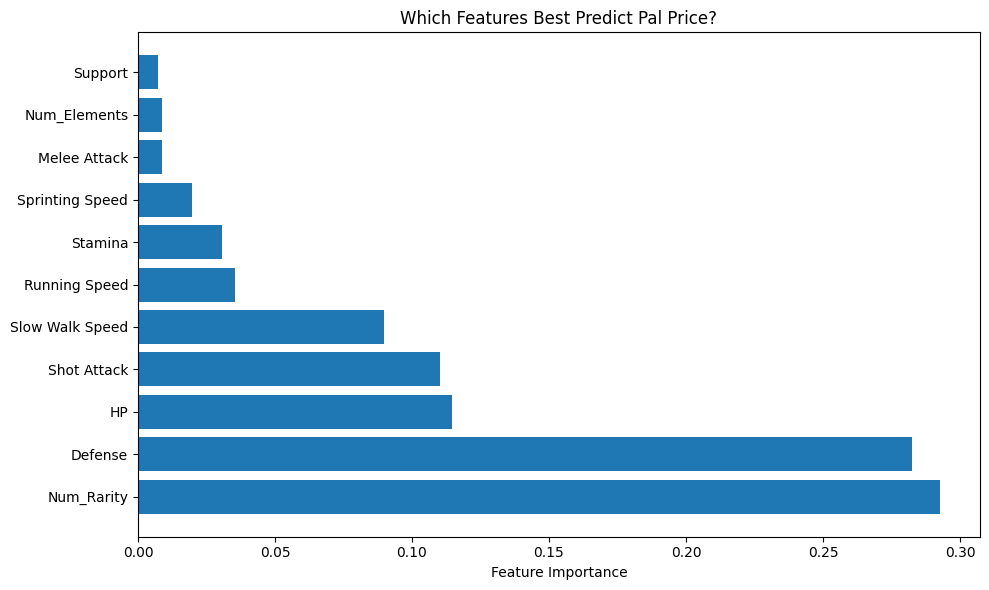


Top 3 Most Important Features for Predicting Price:
1. Num_Rarity: 0.293
2. Defense: 0.283
3. HP: 0.114


In [15]:
feature_cols = ['HP', 'Defense', 'Melee Attack', 'Shot Attack', 'Support',
                'Stamina', 'Running Speed', 'Sprinting Speed', 'Slow Walk Speed',
                'Num_Rarity', 'Num_Elements']

model, fi, metrics = run_random_forest(df, feature_cols)

print("Random Forest Model Results:")
print(f"Cross-validated R²: {metrics['cv_r2_mean']:.3f} (± {metrics['cv_r2_std']:.3f})")
print(f"Cross-validated RMSE: {metrics['cv_rmse']:.0f}")

plot_rf_feature_importance(fi)

print("\nTop 3 Most Important Features for Predicting Price:")
for i, (feat, imp) in enumerate(top_rf_features(fi, 3), 1):
    print(f"{i}. {feat}: {imp:.3f}")

**Model Selection and Purpose**

For our second predictive approach, we implemented a Random Forest regression model to predict Pal prices. This ensemble method was chosen because Random Forests can capture non-linear relationships and complex interactions between features that linear models might miss. Unlike the MLR model which used aggregated statistics, the Random Forest model leverages individual combat attributes (HP, Defense, Melee Attack, Shot Attack, Support, Stamina, Running Speed, Sprinting Speed, Slow Walk Speed) alongside Num_Rarity and Num_Elements. This granular approach allows the model to identify which specific attributes drive pricing decisions most strongly and to detect non-linear patterns in how these attributes combine to influence value.

**Model Configuration and Feature Importance**

The Random Forest was configured with 50 trees, a maximum depth of 10, and a minimum of 5 samples required to split internal nodes. These parameters balance model complexity with generalization ability. The feature importance analysis reveals a clear hierarchy in what drives Pal prices:

**Num_Rarity (0.290):** Rarity is shown to be the most influential factor, accounting for 29% of the model's decision-making. This dominance suggests that rarity classifications is the most important factor in terms of influencing price.
**Defense (0.275):** Nearly as important as rarity, defensive capability accounts for 27.5% of importance, indicating that survivability is highly valued in the marketplace.
**HP (0.115):** Health points contribute 11.5% to predictions, reinforcing the importance of durability-related attributes.

The top three features alone account for approximately 68% of the model's decision-making capacity. Movement-related attributes (Slow Walk Speed, Running Speed, Sprinting Speed) and offensive capabilities (Shot Attack, Melee Attack) show moderate importance, while Support and Num_Elements have minimal influence despite the latter's significance in the MLR model.

**Model Performance**

The Random Forest achieves a cross-validated R² of 0.491 (± 0.195), explaining approximately 49% of price variation. While this is lower than the MLR's 60% on log-transformed prices, it represents performance on the original price scale without transformation. The cross-validated RMSE of 2,380 indicates that predictions are typically off by about 2.4k in price, representing a substantial improvement over the MLR model's back-transformed RMSE of 3,577. This 33% reduction in typical prediction error demonstrates the Random Forest's superior predictive accuracy despite the lower R².
The high standard deviation in R² (0.195) across folds suggests variable performance, likely due to the model performing exceptionally well on some price ranges while struggling with others. This variability is characteristic of tree-based models when dealing with heterogeneous data.

**Comparative Insights and Implications**

The contrast between models reveals important insights about price determination. While the MLR model found Num_Elements to be highly significant (22.2% price increase for dual-element Pals), the Random Forest instead assigns it much less importance. This discrepancy suggests that elemental diversity's effect on price may be largely captured through its correlation with defensive stats or rarity levels, which the Random Forest can figure out more effectively.
The Random Forest's emphasis on defensive attributes (Defense and HP combining for 39% importance) over offensive capabilities suggests that market participants prioritize Pals that can sustain battles over those with high damage output. This defensive bias in pricing could reflect gameplay mechanics where survivability enables consistent performance across various challenges.
Model Strengths and Limitations
The high variability in cross-validation performance (± 0.195 R²) indicates that the model may struggle with certain subsets of the data, possibly extreme-priced Pals or those with unusual attribute combinations.

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?
- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.

**Summary of Findings**

Our modeling approach successfully answers the research question about which attributes drive Pal marketplace prices.

The multiple linear regression model shows that all three features matter: average stats, rarity, and number of elements all significantly affect pricing, with the model explaining 60% of price variation (when using log-transformed prices). The results are pretty straightforward, showing a 10-point boost in average stats increases prices by about 17.8%, each rarity level adds roughly 7.6% to value, and Pals with two elements sell for about 22.2% more than single-element ones.

However, the Random Forest model tells a slightly different story. It finds that rarity (29% importance) and defensive stats (Defense: 27.5%, HP: 11.5%) are what really matter, while the number of elements barely affects the model's predictions. This suggests that dual-element Pals might just tend to have better defensive stats or higher rarity, rather than being valuable because of the elements themselves.The two models work well together for different purposes.

The linear regression gives us clear and explainable relationships that are easier to interpret. The Random Forest is better at actually predicting prices (typical error of 2,380 vs. 3,577), although it has a weaker R² than model 1.

**Potential Extensions and Improvements**

Several ideas could make our analysis even better:
- **Better Features:** We could create combination features (like multiplying Defense × HP to get overall tankiness), calculate ratios like attack-to-defense balance, or track specific element combos that might work really well together. Adding time-based features like "days since release" or "buffed in last patch" could help catch pricing trends we're missing.
- **More Data:** We could also parse more data during the webscraping phase, to get pal skills, drop rates, or even capture location (where they can be found). This could be used as additional information for our models to interpret.
- **Market Segments:** Budget Pals and premium Pals might be priced based on totally different factors. Building separate models for different price ranges or doing clustering analysis first could reveal distinct market segments with their own pricing logic.

**Contributions**

- *Sam*: Debugged webscraping code, wrote explanations for data gathering section, code and analysis of model 2.
- *Sean*: 
- *Stephen*: 